# MSDS7333 Case Study 2
Julien Bataillard
Jared Law
Dennis Murray
Corey Nichols

In [34]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

dateTimeStart = dt.datetime(2016, 1, 1)
dateTimeEnd = dt.datetime(2017, 6, 1)
from pandas_datareader import data as web
stock = 'DPZ'
sp = pd.DataFrame({'DPZ':web.get_data_yahoo(stock, dateTimeStart, dateTimeEnd)['Adj Close']})
names = ['PZZA', 'YUM', 'FRSH', 'MCD', 'KHC', 'PLAY']
for stock in names:
    while True:
        try:
            sp[stock]=web.get_data_yahoo(stock, dateTimeStart, dateTimeEnd)['Adj Close']
            break
        except:
            print('Unable to read stock: {0}'.format(stock))
            print('Trying again')

Unable to read stock: YUM
Trying again


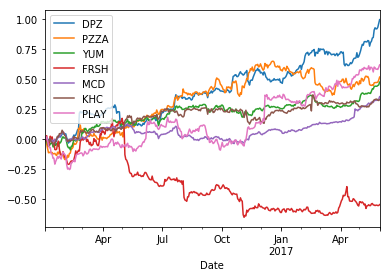

In [35]:
sp = sp.asfreq('B').fillna(method='pad')
rets = sp.pct_change()
((1+rets).cumprod()-1).plot()
plt.show()

In [36]:
def calc_meanRev(price, lookback, lag):
    meanRev = price.shift(lag).pct_change(lookback)
    ranks = meanRev.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

In [37]:
compound = lambda x : (1+x).prod()-1
daily_sr = lambda x : x.mean() / x.std()

def strat_sr(prices, lb, hold):
    freq = '%dB' % hold
    port = calc_meanRev(prices, lb, lag = 1)
    
    daily_rets = prices.pct_change()
    
    port = port.shift(1).resample(freq).first()
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1)
    
    return daily_sr(port_rets) * np.sqrt(252/hold)

In [38]:
strat_sr(sp, 70, 30)

-0.63629781904821858

In [39]:
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(sp, lb, hold)
        
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [40]:
def heatmap(df, cmap = plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap = cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

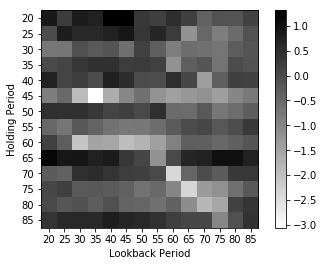

In [41]:
heatmap(ddf)
plt.show()